# Logistic Regression

## Dataset Configuration
Code taken and adjusted from the lab. We import the train and test data from the keras imdb dataset, converting it to the necessary format for the model.

In [1]:
m = 3000    # Number of words in the vocabulary
n = 20      # N most frequent words to skip
k = 20      # K least frequent words to skip

infogain = False # Not used by default
g = 800 

In [2]:
import tensorflow as tf
import numpy as np
from math import log 
from sklearn.model_selection import train_test_split


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_val = np.array([' '.join([index2word[idx] for idx in text]) for text in x_val])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Converts a list of strings into a binary vector. The vector is a list of 0s and 1s, where 1 indicates the presence of a word in the string.
Lab code.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_val_binary = binary_vectorizer.fit_transform(x_val)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = x_train_binary.toarray()
x_val_binary = x_val_binary.toarray()
x_test_binary = x_test_binary.toarray()

X is a matrix of vectors (reviews) where each vector is a binary vector representing the words in the review. 
Y is a vector of labels (0 or 1) where 0 is a negative review and 1 is a positive one.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Information Gain
Performs information gain on the dataset, returning the top g words with the highest information gain. Uses the function from the lab.

In [4]:
from math import log 


if infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0
    for feat in feature_values:
      
      #pf --> P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          #pcf --> P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    ig = Hc - Hc_feature
    return ig    

  # Selecting the g most important features
  ig = [(i, IG(y_train, x_train_binary[:, i])) for i in range(len(x_train_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]

  x_train_binary = x_train_binary[:, [i[0] for i in ig]]
  x_val_binary = x_val_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_binary[:, [i[0] for i in ig]]


## Visualizations
A few visualizations of the results. Utilizes thoroughly adjusted and optimized code from the lab and multiple libraries.

In [5]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from seaborn import heatmap
from pandas import DataFrame
import IPython.display as ipd


def classification_data(estimator, 
                          x_train, y_train,
                          x_test, y_test,
                          splits = 5):
  """
  Trains a model on a training set and evaluates it on both the 
  training and test sets for a given number of splits. Calculates
  the accuracy, precision, recall and F1 score for each split as
  well as the final confusion matrix.  
  
  Arguments:
    estimator obj: The model to be trained and evaluated
    x_train, x_test: The binary training and test data. 
    y_train, y_test: The training and test labels (0 or 1). 
    n_splits: The number of splits to use for training.
  Returns: 
    A dictionary containing the train/test accuracies, precisions,
    recalls and F1 scores as well as the final confusion matrix.
  """

  train_accuracies, test_accuracies, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  # Split the training data into n splits
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  test_cm = None
  
  # Train the model on each split and evaluate on the test set
  for i in range(0, len(x_splits)):
    if i == 0:
      curr_x = x_splits[0]
      curr_y = y_splits[0]
    else:
      curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
      curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    # Train the model and get train/test predictions
    estimator.fit(curr_x, curr_y)
    train_pred = estimator.predict(curr_x)
    test_pred = estimator.predict(x_test)
    
    # Calculate and save the necessary metrics for this train/test split
    train_accuracies.append(accuracy_score(curr_y, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))
    
    train_precisions.append(precision_score(curr_y, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    train_recall.append(recall_score(curr_y, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    train_f1.append(f1_score(curr_y, train_pred))
    test_f1.append(f1_score(y_test, test_pred))
  
  # Calculate the final confusion matrix
  cm = confusion_matrix(y_test, test_pred)
  
  
  # Results required for all the future plots/tables
  return {'estimator': estimator.__class__.__name__, 
          'split_size': split_size, 
          'splits': splits,
          'test_predictions': test_pred,
          'train_accuracy': train_accuracies, 
          'test_accuracy': test_accuracies, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1,
          'final_cm': cm}
  
  
def classification_cm_heatmap(cm, title):
    """
    Creates a heatmap of the confusion matrix.  
    
    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns: 
      A heatmap of the confusion matrix.
    """
    
    
    cm_matrix = DataFrame(data=cm, columns=['Predict Negative: 0', 'Predicted Positive: 1'],
                          index=['Actual Negative: 0', 'Actual Positive: 1'])
    ax = plt.axes()
    ax.set_title('Confusion Matrix Heatmap for {title}'.format(title=title))
    return heatmap(cm_matrix, annot=True, fmt='d')
  
  
def classification_table(classification_data):
  """
  Creates a table of the train/test accuracies, precisions, recalls
  and F1 scores for each split.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
  Returns: 
    A dataframe table of the train/test accuracies, precisions, recalls and F1 scores
  """
    
  split_size = classification_data['split_size']
  df = DataFrame(data={'Train Accuracy': np.round(classification_data['train_accuracy'], 2), 
                         'Test Accuracy': np.round(classification_data['test_accuracy'], 2), 
                         'Precision Train' : np.round(classification_data['train_precision'], 2), 
                         'Precision Test' : np.round(classification_data['test_precision'], 2), 
                         'Recall Train' : np.round(classification_data['train_recall'], 2), 
                         'Recall Test' : np.round(classification_data['test_recall'], 2), 
                         'F1 Train' : np.round(classification_data['train_f1'], 2), 
                         'F1 Test' : np.round(classification_data['test_f1'], 2)}, 
                   index=list(range(split_size, len(x_train) + split_size, split_size)))
  return df


def classification_plots(classification_data, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores.
  """
  
  split_size = classification_data['split_size']
  splits = classification_data['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve for {estimator}".format(estimator=classification_data['estimator']), fontsize=16)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training")
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing")
      axis[i, j].grid(alpha = 0.3)  
  
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
 
  return figure


def classification_plots_compare(classification_data_x, classification_data_y, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure for both classifiers.
  
  Arguments:
    classification_data_x: The dictionary containing the train/test data for the first classifier.
    classification_data_y: The dictionary containing the train/test data for the second classifier.
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores 
    for both classifiers.
  """
  
  split_size = classification_data_x['split_size']
  splits = classification_data_x['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve Comparison for {estimator} against {estimator_2} ".format(estimator=classification_data_x['estimator'], estimator_2=classification_data_y['estimator']), fontsize=12)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#AD49C2", label="Training {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#7CC249", label="Testing {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].grid(alpha = 0.3) 
    
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
  return figure

## Logistic Regression Classification Implementation
A class that implements Logistic Regression for binary classification. The class has two methods: fit and predict. 
The fit method takes in a list of binary vectors and a list of labels and trains the classifier. 
The predict method takes in a list of binary vectors and returns a list of labels.

The variable eta is the learning rate and variable lamda is the regularization weight.

In [6]:
from sklearn.utils import shuffle
from math import log

# Logistic Regression for binary classification
class LogisticRegression:
  def __init__(self, lamda_value=0.001, max_epochs=1000):
    self.weights = None
    self.eta = 0.01
    self.lamda = lamda_value
    self.max_epochs = max_epochs
    self.tolerance = 1e-3
    self.max_no_improvement = 5
  

  def predict(self, X):
    y_pred = list()

    # add a feature equal to 1 for the bias term at the beginning of every example feature vector
    X = np.insert(X, 0, 1, axis=1)

    # for each example vector, if its dot product with the weight vector is greater than 0
    # the algorithms predicts this example to be positive, else it predicts it to be negative
    for x in X:
      y_pred.append(1 if np.dot(self.weights, x) > 0.0 else 0)

    return y_pred
    

  # computes the logistic function using the dot product 
  # of the given example vector and the current weights as argument
  def prob_pos(self, x):
    return 1.0 / (1.0 + np.exp(-np.dot(x, self.weights)))
    

  def fit(self, X, y):    
    
    # add a feature equal to 1 for the bias term at the beginning of every example feature vector
    X = np.insert(X, 0, 1, axis=1)

    examples_num = X.shape[0]
    features_num = X.shape[1]

    # initialize weight array (including bias) with 0s
    self.weights = np.zeros(features_num)    

    # initialize no_improvement counter
    no_improvement = 0   

    # initialize the minimum loss to its maximum value, 1
    min_loss = 1

    # SGD
    # keep running epochs, until you reach the maximum number of epochs or the stopping condition
    for epoch in range(self.max_epochs):

      # shuffle the training example array and the corresponding category array in unison
      # (the index of each example and its category retain the same index in the training and the category array) 
      X, y = shuffle(X, y, random_state=0)

      # initialize the loss for the current epoch at 0
      loss = 0.0

      # go through every example in the training data
      for i in range(examples_num):
        
        # compute the probability of the current example belonging to the positive category
        prob_pos = self.prob_pos(X[i])

        # update weights using the gradient of the loss function and regularization
        self.weights = (1 - 2 * self.lamda * self.eta) * self.weights + self.eta * (y[i] - prob_pos) * X[i]

        # compute the logarithms necessary for computing the loss function
        # in case of zero probility, make it an extremely small value, so that its logarithm can be computed
        if (prob_pos == 0.0):
          prob_pos = 1e-300
        log_prob_pos = log(prob_pos)

        prob_neg = 1.0 - prob_pos       
        if (prob_neg == 0.0):
          prob_neg = 1e-300
        log_prob_neg = log(prob_neg)
        
        # increment the loss function with the (negative of the) log probability 
        # of the current example being classified in the correct category
        loss -= y[i] * log_prob_pos + (1-y[i]) * log_prob_neg

      # normalize loss by dividing with the number of examples
      loss /= examples_num

      # if current loss is below threshold, increment the no_improvement counter
      if loss > min_loss + self.tolerance:
        no_improvement += 1

      # if the current loss is less than the min_loss, reset the no_improvement counter
      # and make current loss the min_loss
      if loss < min_loss:
        no_improvement = 0
        min_loss = loss

      # if the no_improvement counter reached its maximum value, stop running fit()
      if no_improvement == self.max_no_improvement:
        print("Number of training examples =", len(X), ":: Converged at epoch", epoch+1, ":: Loss =", min_loss)
        break

### Optimizing the regularization weights value (lamda)
The above implementation is trained on the training data for multiple lamda values and tested on the validation data. The lamda value that yields the best accuracy score over the validation data is used during the testing of the algorithms performance on the testing data below.


In [7]:
# list containing possible lamda values
lamda_values = [1e-2, 5*1e-3, 1e-3, 5*1e-4, 1e-4]

best_accuracy = 0.0
best_lamda = 0.0

for lamda in lamda_values:
    LogReg = LogisticRegression(lamda)
    print("Checking lamda =", lamda)
    LogReg.fit(x_train_binary, y_train)
    val_pred = LogReg.predict(x_val_binary)
    curr_accuracy = accuracy_score(y_val, val_pred)
    if (curr_accuracy > best_accuracy):
        best_accuracy = curr_accuracy
        best_lamda = lamda
    
print("\nThe lamda value that yields the highest accuracy score over the validation data is:", best_lamda)

Checking lamda = 0.01
Number of training examples = 22500 :: Converged at epoch 13 :: Loss = 0.4048282388721948
Checking lamda = 0.005
Number of training examples = 22500 :: Converged at epoch 16 :: Loss = 0.3644366256213146
Checking lamda = 0.001
Number of training examples = 22500 :: Converged at epoch 28 :: Loss = 0.2877254733117023
Checking lamda = 0.0005
Number of training examples = 22500 :: Converged at epoch 39 :: Loss = 0.26213871044400344
Checking lamda = 0.0001
Number of training examples = 22500 :: Converged at epoch 76 :: Loss = 0.2198386336375397

The lamda value that yields the highest accuracy score over the validation data is: 0.0005


## Logistic Regression for Classification Implementation Results and Analysis
The Logistic Regression for Classification is implemented and tested. The results are visualized and analyzed.

Number of training examples = 4500 :: Converged at epoch 112 :: Loss = 0.13033671401293556
Number of training examples = 9000 :: Converged at epoch 80 :: Loss = 0.19288156581166346
Number of training examples = 13500 :: Converged at epoch 65 :: Loss = 0.23104154058518309
Number of training examples = 18000 :: Converged at epoch 55 :: Loss = 0.25069383985732324
Number of training examples = 22500 :: Converged at epoch 39 :: Loss = 0.26213871044400344
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4500,0.98,0.84,0.99,0.85,0.98,0.84,0.98,0.84
9000,0.95,0.86,0.96,0.86,0.94,0.85,0.95,0.86
13500,0.92,0.86,0.89,0.83,0.96,0.91,0.92,0.87
18000,0.91,0.87,0.88,0.84,0.95,0.91,0.91,0.87
22500,0.91,0.87,0.91,0.87,0.91,0.87,0.91,0.87


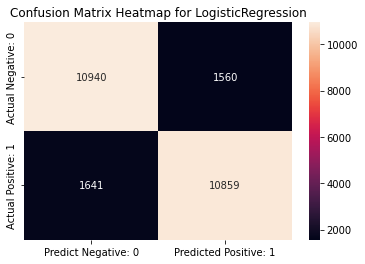

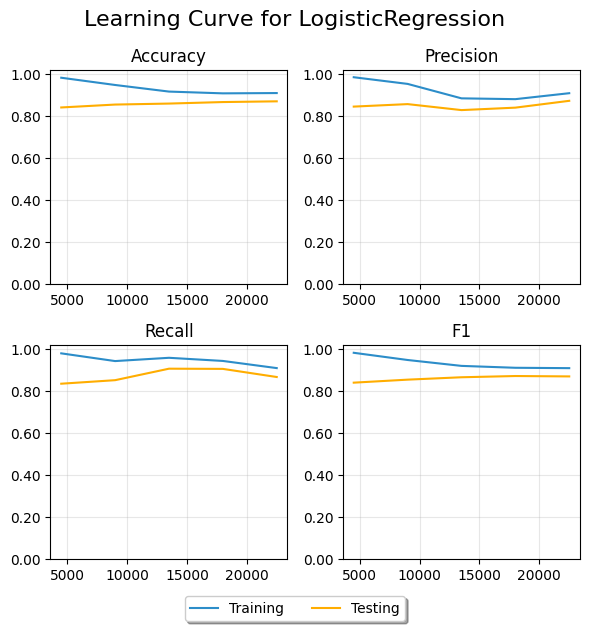

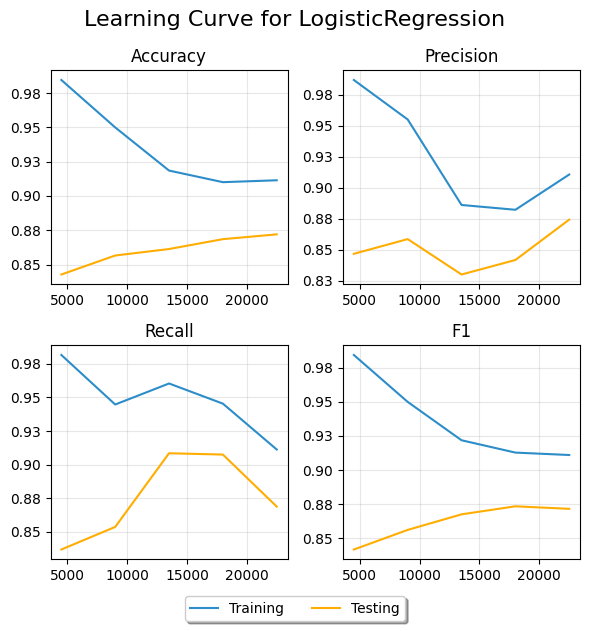

In [8]:
logreg_data = classification_data(LogisticRegression(best_lamda), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, logreg_data['test_predictions']))
logreg_cf_hmp = classification_cm_heatmap(logreg_data['final_cm'], logreg_data['estimator'])
logreg_cf_tbl = classification_table(logreg_data)
ipd.display(logreg_cf_tbl)

logreg_cf_tplt = classification_plots(logreg_data, True)
logreg_cf_fplt = classification_plots(logreg_data)

### Logistic Regression against SKLearn's Logistic Regression
The Logistic Regression implementation is tested against the SKLearn Stochastic Gradient Descent Classifier, set up to also use the log loss function. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4500,-0.020000,0.020000,-0.010000,0.030000,-0.020000,0.020000,-0.020000,0.020000
9000,-0.040000,0.030000,-0.020000,0.040000,-0.050000,0.010000,-0.040000,0.030000
13500,-0.030000,0.020000,-0.040000,0.010000,-0.020000,0.040000,-0.030000,0.020000
18000,-0.020000,0.020000,-0.030000,0.000000,-0.010000,0.030000,-0.020000,0.010000
22500,-0.020000,0.010000,0.000000,0.020000,-0.030000,0.000000,-0.020000,0.010000


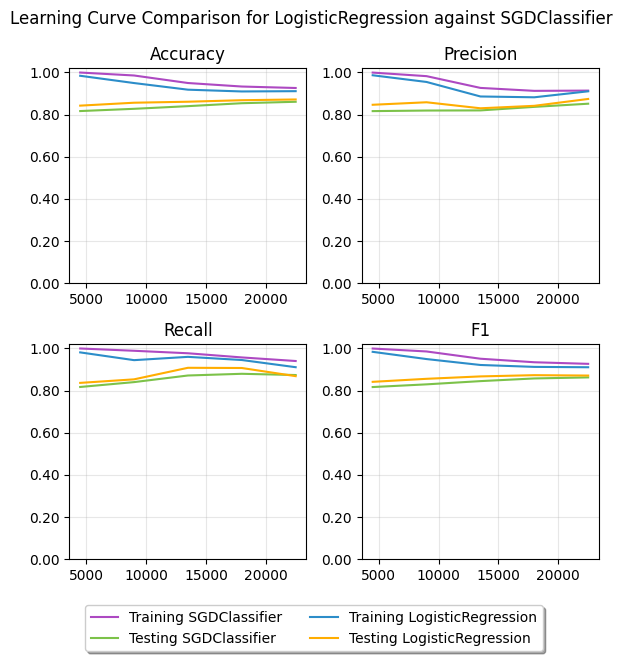

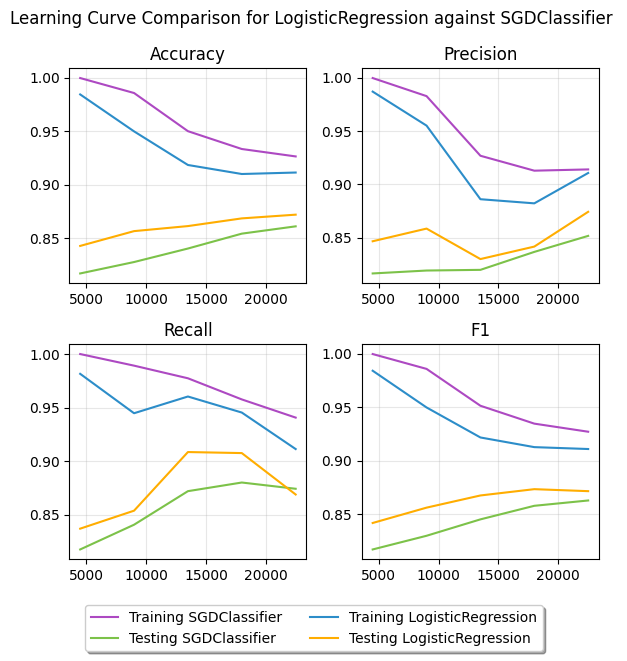

In [9]:
from sklearn.linear_model import SGDClassifier

sklogreg_data = classification_data(SGDClassifier(loss='log_loss'), x_train_binary, y_train, x_test_binary, y_test, 5)
# sklogreg_cf_hmp = classification_cm_heatmap(sklogreg_data['final_cm'], sklogreg_data['estimator'])
sklogreg_cf_tbl = classification_table(sklogreg_data)
logreg_sklogreg_tbl = logreg_cf_tbl - sklogreg_cf_tbl
logreg_sklogreg_tbl = logreg_sklogreg_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=logreg_data['estimator'], estimator_2=sklogreg_data['estimator']))
ipd.display(logreg_sklogreg_tbl)

logreg_sklogreg_tplt = classification_plots_compare(logreg_data, sklogreg_data, True)
logreg_sklogreg_fplt = classification_plots_compare(logreg_data, sklogreg_data)

### Logistic Regression against SKLearn's Bernoulli Naive Bayes
The Logistic Regression implementation is tested against the SKLearn Bernoulli Naive Bayes Classifier. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4500,0.100000,0.010000,0.120000,0.030000,0.090000,0.000000,0.100000,0.010000
9000,0.080000,0.020000,0.090000,0.020000,0.070000,0.020000,0.080000,0.020000
13500,0.060000,0.020000,0.040000,-0.010000,0.090000,0.070000,0.060000,0.030000
18000,0.050000,0.030000,0.030000,0.000000,0.080000,0.070000,0.050000,0.030000
22500,0.060000,0.030000,0.060000,0.030000,0.050000,0.030000,0.060000,0.030000


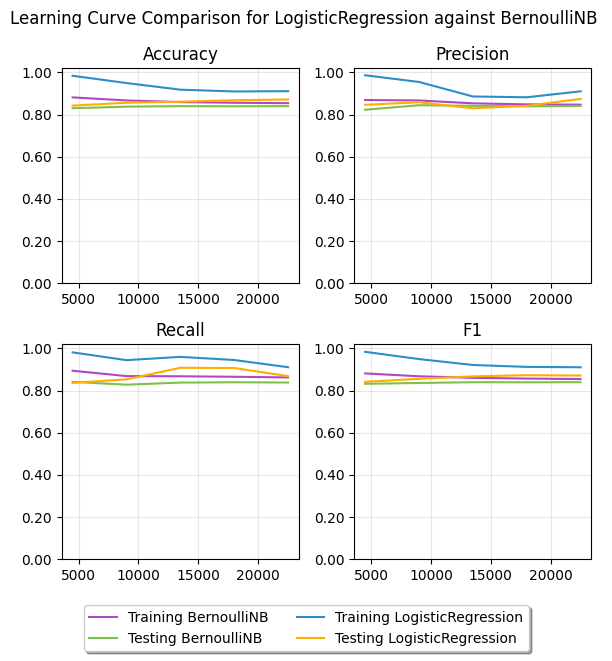

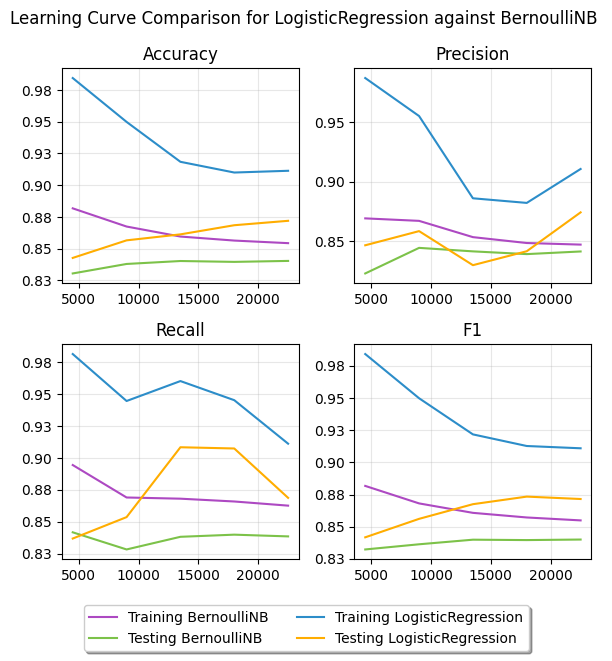

In [10]:
from sklearn.naive_bayes import BernoulliNB

skbnb_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
#skbnb_cf_hmp = classification_cm_heatmap(skbnb_data['final_cm'], skbnb_data['estimator'])
skbnb_cf_tbl = classification_table(skbnb_data)
logreg_skbnb_tbl = logreg_cf_tbl - skbnb_cf_tbl
logreg_skbnb_tbl = logreg_skbnb_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=logreg_data['estimator'], estimator_2=skbnb_data['estimator']))
ipd.display(logreg_skbnb_tbl)

bnb_skbnb_tplt = classification_plots_compare(logreg_data, skbnb_data, True)
bnb_skbnb_fplt = classification_plots_compare(logreg_data, skbnb_data)

## Logistic Regression against SKLearn's Decision Tree
The Logistic Regression implementation is tested against the SKLearn Decision Tree. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
4500,0.200000,0.130000,0.270000,0.190000,0.050000,-0.020000,0.170000,0.090000
9000,0.180000,0.150000,0.250000,0.190000,0.040000,0.000000,0.160000,0.110000
13500,0.160000,0.150000,0.160000,0.150000,0.140000,0.130000,0.150000,0.140000
18000,0.150000,0.140000,0.170000,0.160000,0.070000,0.070000,0.120000,0.120000
22500,0.160000,0.150000,0.210000,0.190000,0.030000,0.020000,0.130000,0.120000


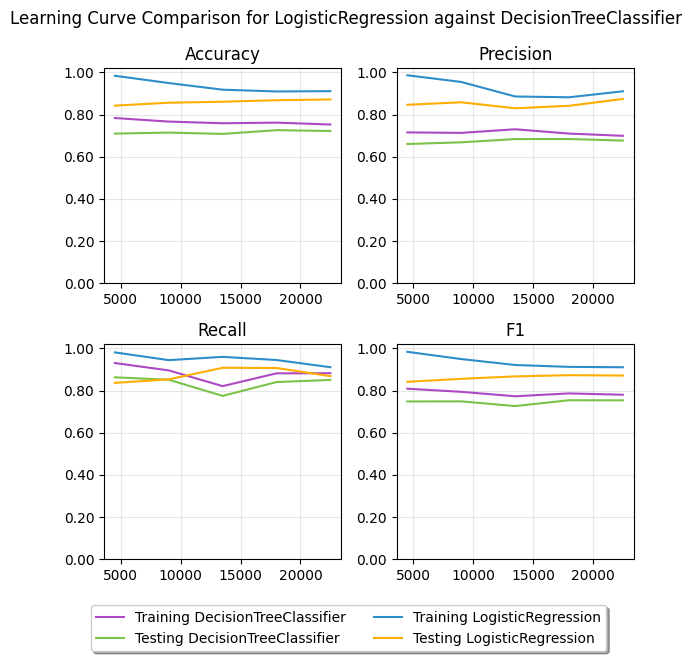

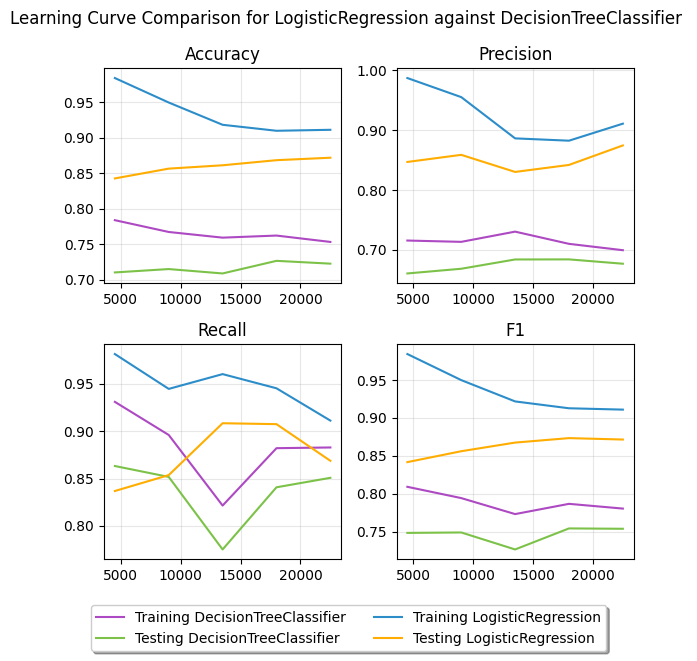

In [11]:
from sklearn.tree import DecisionTreeClassifier

skDT_data = classification_data(DecisionTreeClassifier(criterion='entropy',max_depth=10), x_train_binary, y_train, x_test_binary, y_test, 5)
# skDT_cf_hmp = classification_cm_heatmap(skDT_data['final_cm'], skDT_data['estimator'])
skDT_cf_tbl = classification_table(skDT_data)

logreg_skDT_tbl = logreg_cf_tbl - skDT_cf_tbl
logreg_skDT_tbl = logreg_skDT_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=logreg_data['estimator'], estimator_2=skDT_data['estimator']))
ipd.display(logreg_skDT_tbl)

IDE_skDT_tplt = classification_plots_compare(logreg_data, skDT_data, True)
IDE_skDT_fplt = classification_plots_compare(logreg_data, skDT_data)